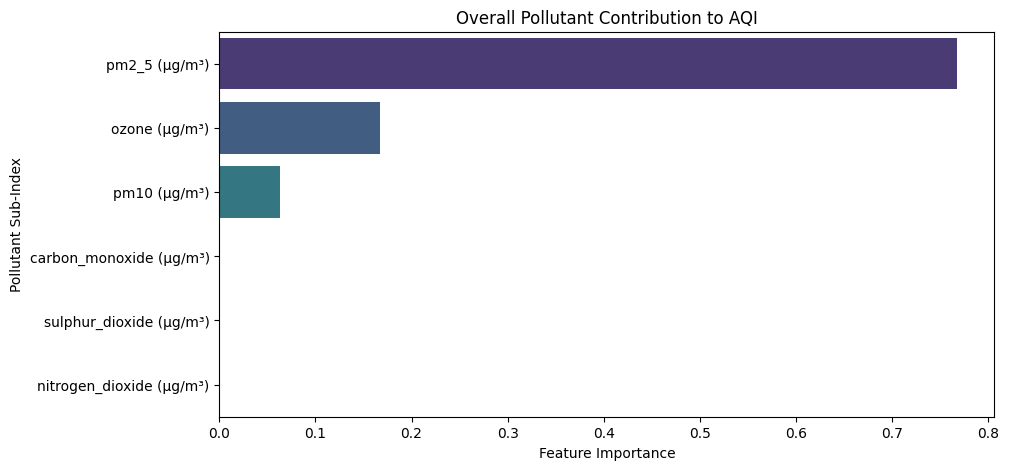

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset (daily or hourly, depending on analysis scope)
df = pd.read_csv("..//data/featureddata/featured_daily.csv")  # Replace with 'featured_hourly.csv' for hourly trends

# Define features (pollutant sub-indices) and target (AQI)
# Define Features (Use Raw Pollutant Concentrations)
X = df[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]
# Define Target
y = df["AQI"]  # Only for training feature importance model, not for AQI prediction

# Split dataset (to prevent overfitting while assessing feature importance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model for Feature Importance Analysis
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, hue="Feature", palette="viridis", legend=False)
plt.xlabel("Feature Importance")
plt.ylabel("Pollutant Sub-Index")
plt.title("Overall Pollutant Contribution to AQI")
plt.show()



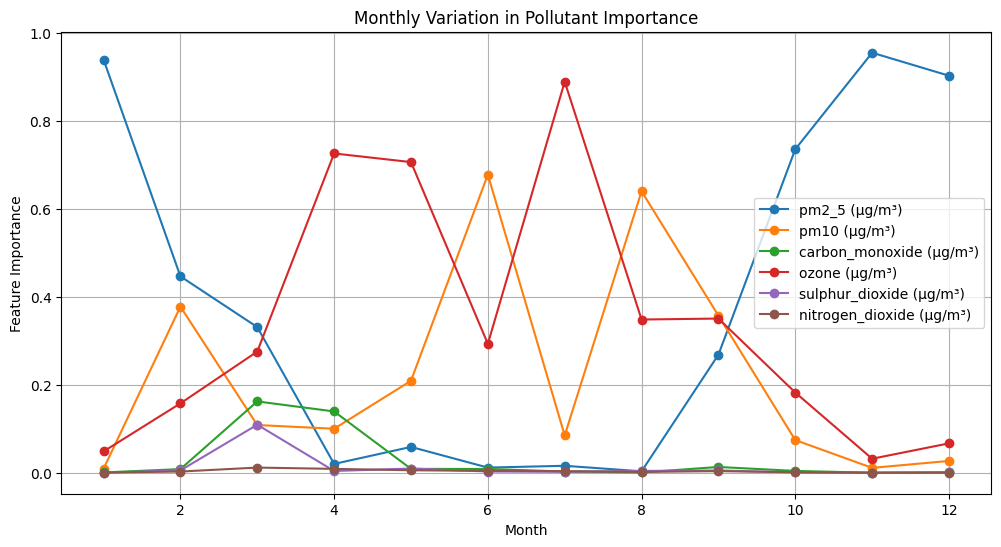

In [2]:
# Temporal Feature Importance Analysis
monthly_importance = []
months_available = sorted(df["month"].unique())

for month in months_available:
    df_month = df[df["month"] == month]
    if len(df_month) >= 30:  # Ensure enough data points per month
        X_month = df_month[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]

        y_month = df_month["AQI"]
        rf_month = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_month.fit(X_month, y_month)
        monthly_importance.append(rf_month.feature_importances_)
    else:
        monthly_importance.append([np.nan] * len(feature_names))  # Placeholder for missing months

monthly_importance = np.array(monthly_importance).T

# Plot Temporal Feature Importance Trends
plt.figure(figsize=(12, 6))
for i, feature in enumerate(feature_names):
    plt.plot(months_available, monthly_importance[i], label=feature, marker='o')
plt.xlabel("Month")
plt.ylabel("Feature Importance")
plt.title("Monthly Variation in Pollutant Importance")
plt.legend()
plt.grid(True)
plt.show()


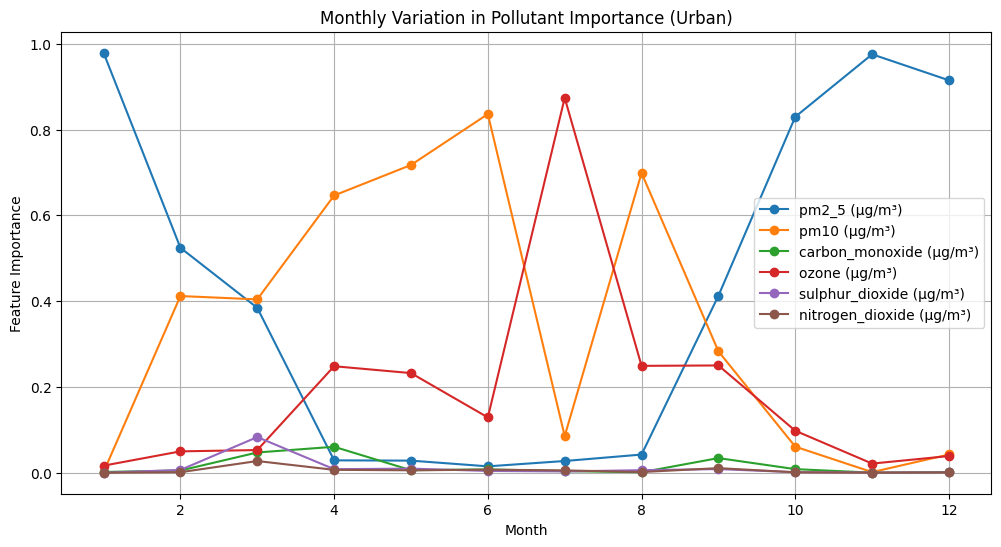

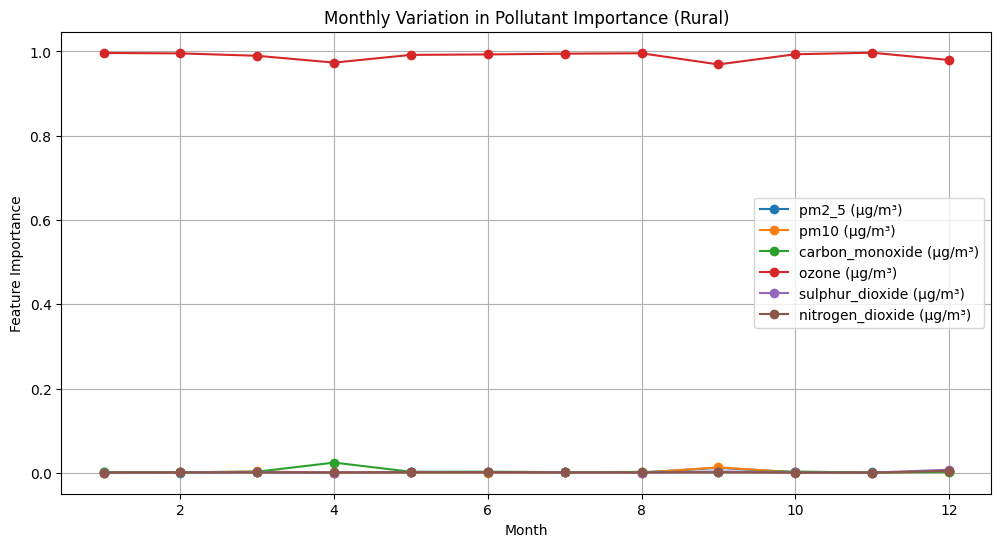

In [5]:
# Spatio-Temporal Analysis (Urban vs Rural & Location-Based)
if "Location" in df.columns and "Urban/Rural" in df.columns:
    locations = df["Location"].unique()
    urban_rural_categories = df["Urban/Rural"].unique()
    
    for category in urban_rural_categories:
        df_category = df[df["Urban/Rural"] == category]
        feature_importance_urban_rural = []
        
        for month in months_available:
            df_month = df_category[df_category["month"] == month]
            if len(df_month) >= 30:
                X_month = df_month[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]
                y_month = df_month["AQI"]
                rf_month = RandomForestRegressor(n_estimators=100, random_state=42)
                rf_month.fit(X_month, y_month)
                feature_importance_urban_rural.append(rf_month.feature_importances_)
            else:
                feature_importance_urban_rural.append([np.nan] * len(feature_names))
        
        feature_importance_urban_rural = np.array(feature_importance_urban_rural).T
        
        plt.figure(figsize=(12, 6))
        for i, feature in enumerate(feature_names):
            plt.plot(months_available, feature_importance_urban_rural[i], label=feature, marker='o')
        plt.xlabel("Month")
        plt.ylabel("Feature Importance")
        plt.title(f"Monthly Variation in Pollutant Importance ({category})")
        plt.legend()
        plt.grid(True)
        plt.show()


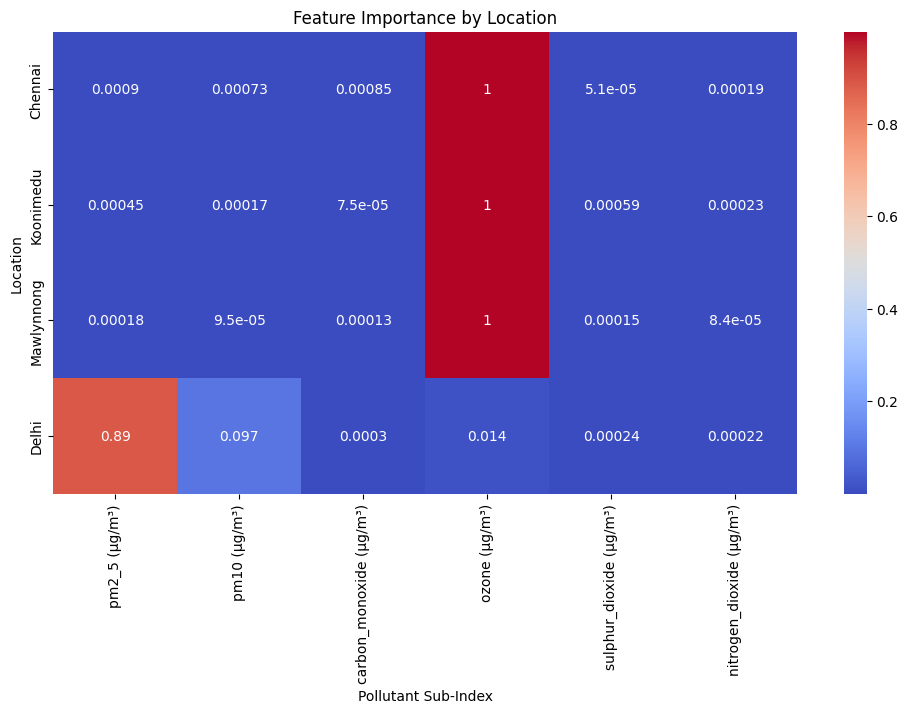

In [7]:
# Location-Based Feature Importance
if "Location" in df.columns and "Urban/Rural" in df.columns:
    locations = df["Location"].unique()
    urban_rural_categories = df["Urban/Rural"].unique()
    location_importance = []
    location_labels = []
    for location in locations:
        df_location = df[df["Location"] == location]
        if len(df_location) >= 3:
            X_location = df_location[["pm2_5 (μg/m³)", "pm10 (μg/m³)", 
        "carbon_monoxide (μg/m³)", "ozone (μg/m³)", 
        "sulphur_dioxide (μg/m³)", "nitrogen_dioxide (μg/m³)"]]
            y_location = df_location["AQI"]
            rf_location = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_location.fit(X_location, y_location)
            location_importance.append(rf_location.feature_importances_)
            location_labels.append(location)
    
    if location_importance:  # Ensure non-empty importance data
        location_importance = np.array(location_importance)
        plt.figure(figsize=(12, 6))
        sns.heatmap(location_importance, cmap="coolwarm", annot=True, xticklabels=feature_names, yticklabels=location_labels)
        plt.xlabel("Pollutant Sub-Index")
        plt.ylabel("Location")
        plt.title("Feature Importance by Location")
        plt.show()
    else:
        print("Insufficient data for location-based feature importance analysis.")